In [1]:
import pandas as pd
import numpy as np

import seaborn as sns

from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import reservoir as rdl

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
scaler = StandardScaler()

import umap

In [4]:
salts = ["phosphate", "hydrochloride", "hydrochloride monohydrate", "acetate", "sulfate"]

def remove_salts(name, salts):
    """
    Remove salt from drug name
    """
    clean_name = name
    for salt in salts:
        try:
            clean_name = re.findall(f"(.+) {salt}", name)[0]
        except:
            continue
    return clean_name

In [5]:
embeddings = pd.read_csv('drug_embeddings_after_round_5.csv')
embeddings.set_index('recover_id', inplace=True)
embeddings = embeddings.loc[:,embeddings.std() != 0]

# Get drug info from datalake
drugs = rdl.get_drugs()
recover_drugs = drugs[drugs["recover_id"].isin(embeddings.index)]

In [6]:
# Some drugs don't have a common name in that table (name is reported as a RE-MOL ID)
no_name = recover_drugs[recover_drugs["name"].str.match("RE-MOL")]

In [7]:
f"{len(no_name)} of {len(recover_drugs)} drugs don't have a common name in this table"

"24 of 152 drugs don't have a common name in this table"

In [8]:
# Retrieve extended drug name table
# This table is on the datalake and can include several names for each drug
# I hope to find here some of the "missing" names
all_names = pd.read_csv(rdl.RESERVOIR_DATA_FOLDER + "/parsed/drugs/drug_names.csv")

In [9]:
# Find missing names (keep the first name that appears in extended table)
get_names = no_name.drop(columns="name").merge(all_names, on="recover_id")[["recover_id", "name"]]
unique_names = get_names.groupby("recover_id").first().reset_index()

Unfortunately, we found only 7 of the missing names.

In [10]:
# Updated name list with the 7 found

update_names = pd.concat([unique_names, recover_drugs[["recover_id", "name"]]]).drop_duplicates(subset=["recover_id"]).reset_index(drop=True)

update_names

,recover_id,name
0,RE-MOL-0000014222,clofibrate
1,RE-MOL-0000016073,celecoxib
2,RE-MOL-0000028829,vandetanib
3,RE-MOL-0000031117,entinostat
4,RE-MOL-0000334530,theophylline
...,...,...
147,RE-MOL-0001319071,gsk-2636771
148,RE-MOL-0001376287,spebrutinib
149,RE-MOL-0001495681,ribociclib
150,RE-MOL-0001495720,poziotinib


In [11]:
# Replace index with drug name, note that 17 will still be RE-MOL IDs
embeddings_with_name = embeddings.merge(update_names, left_index=True, right_on="recover_id")
embeddings_with_name.index = embeddings_with_name["name"]
embeddings_with_name = embeddings_with_name.drop(columns=["recover_id", "name"])

embeddings_with_name

,drug_emb_0,drug_emb_1,drug_emb_3,drug_emb_4,drug_emb_5,drug_emb_6,drug_emb_7,drug_emb_8,drug_emb_9,drug_emb_10,...,BMP2K,TNIK,STK16,TAOK3,NUAK2,IRAK3,TBK1,LRRK2,MET,ROS1
name,,,,,,,,,,,,,,,,,,,,,
exemestane,0.000000,0.119342,0.126332,0.426057,0.263459,0.337314,0.218921,0.302472,0.108330,0.179806,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
vincristine sulfate,0.000000,0.159847,0.714492,0.556659,0.295664,0.937093,0.809534,0.785357,0.440828,0.614883,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
imatinib,0.000000,0.487898,0.418699,1.079710,0.672570,0.682876,0.587821,0.858660,0.216299,0.425320,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
romidepsin,0.000000,0.166266,0.261527,0.379476,0.212590,0.503415,0.300992,0.435198,0.213455,0.212019,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mitotane,0.000000,0.423462,0.392933,0.426187,0.290820,0.453417,0.410824,0.499955,0.308427,0.390667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hexylcaine,0.001233,0.148584,0.194376,0.563332,0.409911,0.326904,0.274799,0.461500,0.200760,0.187953,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
alfacalcidol,0.000000,0.000000,0.639679,0.839975,0.698662,0.992736,0.831530,0.837766,0.749081,0.647068,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
isotretinoin,0.000000,0.239635,0.275742,0.557301,0.337493,0.468015,0.392815,0.527238,0.200213,0.287572,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
del embeddings
del unique_names
del all_names
del no_name
del recover_drugs

In [13]:
data_mat = embeddings_with_name.iloc[:,0:102].T.copy()
embeddings_with_name.drop(columns=embeddings_with_name.iloc[:,0:102].columns, inplace=True)

In [14]:
# Drugs for which a common name has not been found

embeddings_with_name[embeddings_with_name.index.str.match("RE-MOL")]

,DRD2,ADRA1A,ADRA1D,ADRA2A,ADRA2C,ADRA2B,HSD17B10,DRD3,SIGMAR1,HTR2C,...,BMP2K,TNIK,STK16,TAOK3,NUAK2,IRAK3,TBK1,LRRK2,MET,ROS1
name,,,,,,,,,,,,,,,,,,,,,
RE-MOL-0000017147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RE-MOL-0000000470,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RE-MOL-0000075422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RE-MOL-0000801341,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RE-MOL-0000311663,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RE-MOL-0000017437,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RE-MOL-0000017325,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RE-MOL-0000192053,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RE-MOL-0000020425,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot: ylabel='Count'>

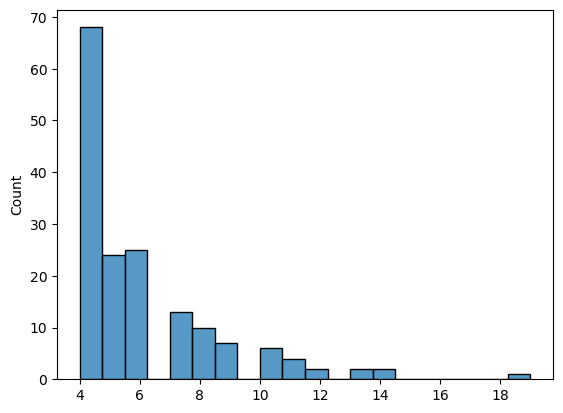

In [15]:
sns.histplot(embeddings_with_name.sum(), bins= 20)

In [16]:
np.sort( embeddings_with_name.sum() )

array([ 4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
        4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
        4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
        4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
        4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
        4.,  4.,  4.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
        5.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
        7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  9.,  9.,  9.,
        9.,  9.,  9.,  9., 10., 10., 10., 10., 10., 10., 11., 11., 11.,
       11., 12., 12., 13., 13., 14., 14., 19.])

In [17]:
kill_col = embeddings_with_name.columns[embeddings_with_name.sum() < 6]
print(kill_col)

Index(['DRD2', 'ADRA1A', 'HSD17B10', 'HTR6', 'CHRM2', 'CHRM3', 'CHRM1',
       'SLC6A2', 'TSHR', 'THRB', 'ACHE', 'ESR2', 'KCNH2', 'TUBB6', 'TUBB2B',
       'TUBB2A', 'TUBA3E', 'TUBA1C', 'TUBA1B', 'TUBB', 'TUBB8', 'TUBB4A',
       'TUBA1A', 'TUBB3', 'TUBA4A', 'TUBA3C', 'TUBB1', 'TUBB4B', 'RAB9A',
       'HDAC2', 'HDAC6', 'HDAC3', 'HDAC1', 'MAPK11', 'NR3C1', 'CA9', 'CA12',
       'CA14', 'CA6', 'MAPK1', 'HIF1A', 'RPS6KB1', 'FER', 'MINK1', 'EPHA5',
       'MKNK1', 'ERBB3', 'MERTK', 'ULK3', 'MAP2K1', 'FYN', 'RAF1', 'TYK2',
       'MAP3K20', 'YES1', 'BTK', 'EPHB2', 'EPHB1', 'EPHA4', 'LIMK1', 'EPHA3',
       'TNK2', 'PTK6', 'BCR', 'EPHA1', 'MAP4K3', 'MAP3K3', 'STK35', 'TEK',
       'MKNK2', 'EPHA7', 'CDK7', 'HIPK2', 'MAP3K7', 'MUSK', 'HIPK3', 'IRAK1',
       'RPS6KA1', 'TYRO3', 'FGFR2', 'PTK2', 'TTK', 'BMP2K', 'TNIK', 'STK16',
       'TAOK3', 'NUAK2', 'IRAK3', 'TBK1', 'LRRK2', 'MET', 'ROS1'],
      dtype='object')


In [18]:
embeddings_with_name.drop(columns=kill_col, inplace= True)

In [19]:
pca = PCA(n_components=10)
pca_fit = pca.fit(data_mat)

In [20]:
embeddings_with_name

,ADRA1D,ADRA2A,ADRA2C,ADRA2B,DRD3,SIGMAR1,HTR2C,HTR2A,HTR2B,CHRM4,...,MAP4K1,EPHB6,MAP3K2,NTRK2,NTRK3,FLT1,AURKA,PLK4,AXL,FGFR3
name,,,,,,,,,,,,,,,,,,,,,
exemestane,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
vincristine sulfate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
imatinib,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
romidepsin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mitotane,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hexylcaine,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
alfacalcidol,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
isotretinoin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# embeddings_with_name.to_csv('~/shared_data/scripps_oncology/embeddings_with_name.csv', sep='\t')

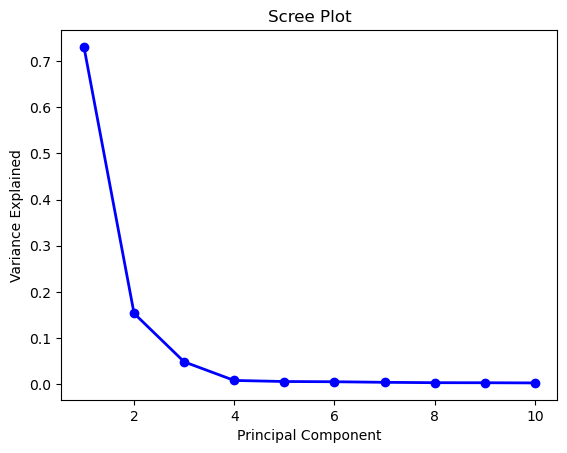

In [22]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values,  pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [23]:
pca.explained_variance_ratio_[0:10]*100

array([73.11000338, 15.33373787,  4.81600887,  0.7835855 ,  0.55076917,
        0.50188722,  0.37654168,  0.2955564 ,  0.28415821,  0.24526786])

In [24]:
new_df = pd.DataFrame( data= pca_fit.components_[0:5, :].T, 
                      index=embeddings_with_name.index, 
                      columns=['PC1','PC2','PC3','PC4','PC5'])

In [25]:
reducer = umap.UMAP()
UMAP_embedding = reducer.fit_transform(new_df)
new_df['UMAP1'] = UMAP_embedding[:,0]
new_df['UMAP2'] = UMAP_embedding[:,1]


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


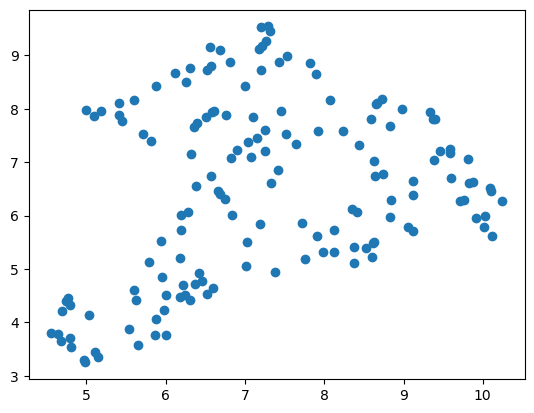

In [26]:
plt.scatter(
    UMAP_embedding[:, 0],
    UMAP_embedding[:, 1])

In [27]:
embeddings_with_name = embeddings_with_name.join(new_df)

In [28]:
target_mat = embeddings_with_name.T.copy()

In [29]:
pcaT = PCA(n_components=10)
pcaT_fit = pcaT.fit(target_mat)

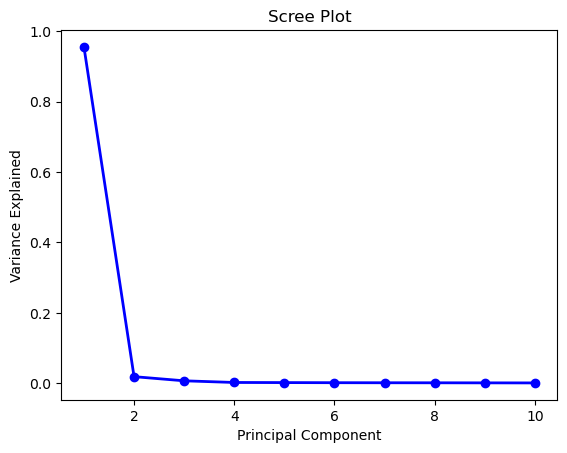

In [30]:
PC_values = np.arange(pcaT.n_components_) + 1
plt.plot(PC_values, pcaT.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [31]:
pcaT.explained_variance_ratio_[0:5]*100

array([95.59207035,  1.86530585,  0.68361577,  0.21105434,  0.17730705])

In [32]:
new_Tdf = pd.DataFrame( data= pcaT_fit.components_[0:3, :].T, index=embeddings_with_name.index)

In [33]:
embeddings_with_name = embeddings_with_name.join( new_Tdf)

In [34]:
embeddings_with_name

,ADRA1D,ADRA2A,ADRA2C,ADRA2B,DRD3,SIGMAR1,HTR2C,HTR2A,HTR2B,CHRM4,...,PC1,PC2,PC3,PC4,PC5,UMAP1,UMAP2,0,1,2
name,,,,,,,,,,,,,,,,,,,,,
exemestane,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.061077,-0.007191,-0.017790,-0.025370,-0.065078,7.325490,6.619646,0.081624,0.000395,0.001327
vincristine sulfate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.102256,0.227623,-0.009772,-0.104202,-0.137034,10.024315,5.985438,0.094596,-0.133009,0.055525
imatinib,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.138372,-0.078390,0.099714,0.110155,0.072229,7.427531,8.885958,0.092572,0.094580,-0.129370
romidepsin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.056893,0.062416,-0.014169,-0.111185,-0.000290,9.059725,5.795036,0.087711,-0.104768,0.026287
mitotane,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.061340,0.027553,0.079200,0.087673,0.021551,7.172645,9.124162,0.094344,0.119562,-0.002262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hexylcaine,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.070182,-0.018417,-0.041071,0.002571,-0.033773,6.180660,5.200338,0.066736,-0.016530,0.005176
alfacalcidol,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.109397,0.247545,-0.163130,0.167291,-0.291717,10.118844,5.624176,0.093264,-0.153714,0.038748
isotretinoin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.079681,-0.001661,0.041160,0.021116,-0.058868,6.612996,7.957503,0.084473,0.089554,-0.001520


In [35]:
tmp_cols = embeddings_with_name[[0, 1, 2]].copy()
tmp_cols = tmp_cols - tmp_cols.quantile(q=0.1)
tmp_cols = tmp_cols / tmp_cols.quantile(q=0.9)
tmp_cols[tmp_cols < 0] = 0
tmp_cols[tmp_cols > 1] = 1
mean_pt = tmp_cols.mean(axis=0)
tmp_cols['div'] = np.sqrt( (tmp_cols.iloc[:,0] - mean_pt[0])**2 + (tmp_cols.iloc[:,1] - mean_pt[1])**2 + (tmp_cols.iloc[:,2] - mean_pt[2])**2 )
tmp_cols['div'] = tmp_cols['div']/tmp_cols['div'].max()

tmp_cols = tmp_cols.values

<AxesSubplot: ylabel='Count'>

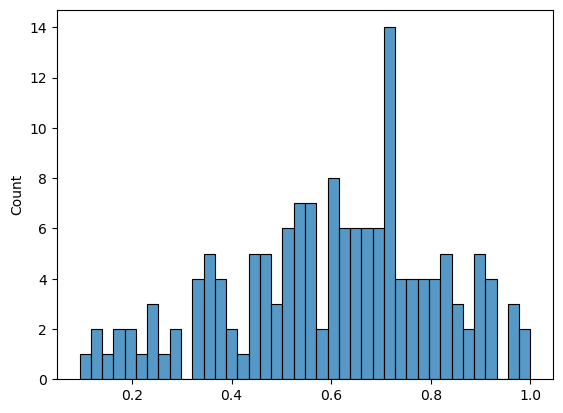

In [36]:
sns.histplot(tmp_cols[:,3] , bins=40)

In [37]:
embeddings_with_name_tmp = embeddings_with_name.copy()
embeddings_with_name_tmp = embeddings_with_name_tmp[tmp_cols[:,3] > 0.60]
embeddings_with_name_tmp = embeddings_with_name_tmp[~embeddings_with_name_tmp.index.str.contains('RE-')]
kill_list =  ['gsk-2636771', 'pd-0325901', '7-ethyl-10-hydroxy-camptothecin','bms-582949','hhgv-678', '[11c]-sorafenib', '[11c]epinephrine', 'wr-1065',  'pki-166' ]
embeddings_with_name_tmp = embeddings_with_name_tmp[~embeddings_with_name_tmp.index.isin(kill_list) ]
embeddings_with_name_tmp.index = [remove_salts(drug, salts) for drug in embeddings_with_name_tmp.index]

In [38]:
embeddings_with_name_tmp.rename(index={'methotrexate sodium': 'methotrexate'}, inplace=True)

In [39]:
embeddings_with_name_tmp.reset_index()

,index,ADRA1D,ADRA2A,ADRA2C,ADRA2B,DRD3,SIGMAR1,HTR2C,HTR2A,HTR2B,...,PC1,PC2,PC3,PC4,PC5,UMAP1,UMAP2,0,1,2
0,vincristine sulfate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.102256,0.227623,-0.009772,-0.104202,-0.137034,10.024315,5.985438,0.094596,-0.133009,0.055525
1,imatinib,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.138372,-0.078390,0.099714,0.110155,0.072229,7.427531,8.885958,0.092572,0.094580,-0.129370
2,mitotane,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.061340,0.027553,0.079200,0.087673,0.021551,7.172645,9.124162,0.094344,0.119562,-0.002262
3,celecoxib,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.076246,0.059887,0.112466,0.033486,0.055922,7.826013,8.863579,0.096581,0.083446,0.018525
4,vorinostat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.058724,0.036452,0.031744,0.040932,-0.007362,7.002220,8.431452,0.089615,0.093120,-0.016842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,azacitidine,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.062418,0.032675,0.024025,-0.059080,-0.067534,9.825641,6.613134,0.096662,-0.097480,0.058691
65,toremifene,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.109815,-0.084813,0.075040,0.087872,-0.008881,7.206287,8.732018,0.092373,0.099310,-0.001953
66,estradiol,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.056144,-0.023840,-0.037125,-0.028279,-0.035572,6.419467,4.930036,0.066291,-0.033914,0.059227
67,sirolimus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.095571,0.040992,-0.076837,-0.161225,0.116397,8.627982,5.498060,0.083261,-0.101929,0.040594


In [40]:
embeddings_with_name_tmp.index = embeddings_with_name_tmp.index.str.capitalize()

In [41]:
embeddings_with_name_tmp

,ADRA1D,ADRA2A,ADRA2C,ADRA2B,DRD3,SIGMAR1,HTR2C,HTR2A,HTR2B,CHRM4,...,PC1,PC2,PC3,PC4,PC5,UMAP1,UMAP2,0,1,2
Vincristine sulfate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.102256,0.227623,-0.009772,-0.104202,-0.137034,10.024315,5.985438,0.094596,-0.133009,0.055525
Imatinib,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.138372,-0.078390,0.099714,0.110155,0.072229,7.427531,8.885958,0.092572,0.094580,-0.129370
Mitotane,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.061340,0.027553,0.079200,0.087673,0.021551,7.172645,9.124162,0.094344,0.119562,-0.002262
Celecoxib,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.076246,0.059887,0.112466,0.033486,0.055922,7.826013,8.863579,0.096581,0.083446,0.018525
Vorinostat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.058724,0.036452,0.031744,0.040932,-0.007362,7.002220,8.431452,0.089615,0.093120,-0.016842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Azacitidine,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.062418,0.032675,0.024025,-0.059080,-0.067534,9.825641,6.613134,0.096662,-0.097480,0.058691
Toremifene,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.109815,-0.084813,0.075040,0.087872,-0.008881,7.206287,8.732018,0.092373,0.099310,-0.001953
Estradiol,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.056144,-0.023840,-0.037125,-0.028279,-0.035572,6.419467,4.930036,0.066291,-0.033914,0.059227
Sirolimus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.095571,0.040992,-0.076837,-0.161225,0.116397,8.627982,5.498060,0.083261,-0.101929,0.040594


In [42]:
from adjustText import adjust_text

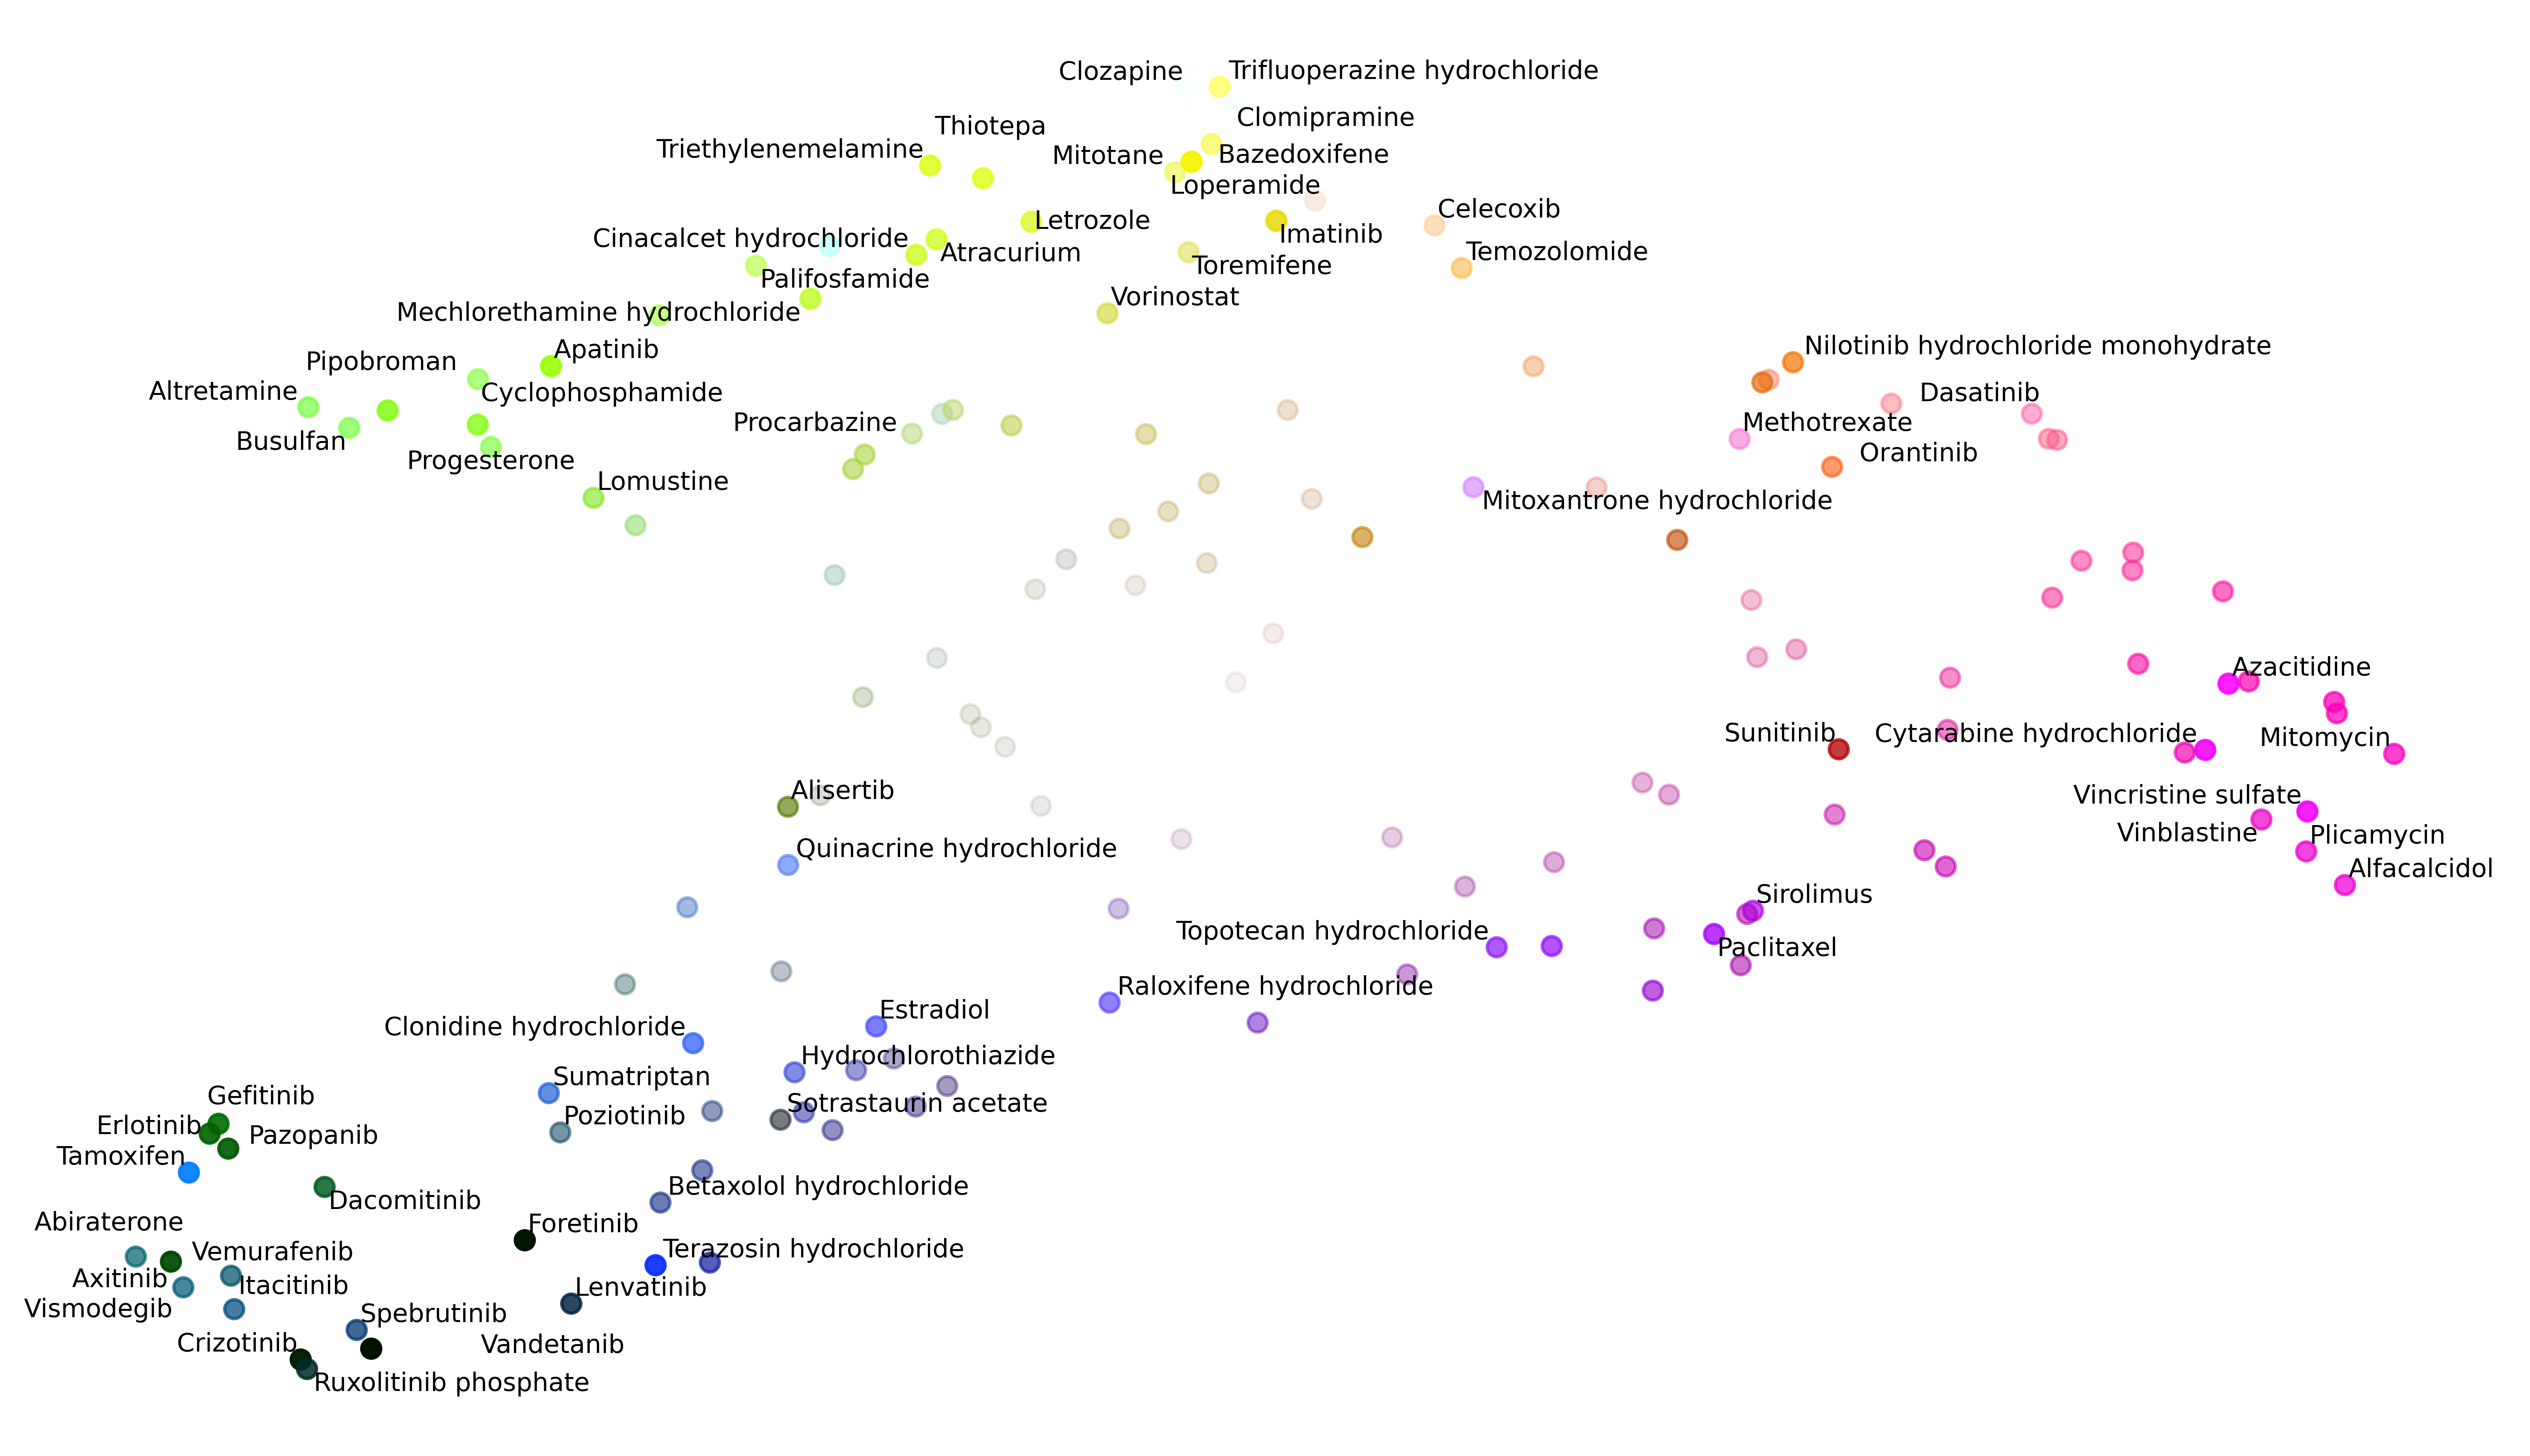

<Figure size 640x480 with 0 Axes>

In [43]:
figure(figsize=(14, 8), dpi=800)
plt.scatter( x = embeddings_with_name['UMAP1'], y = embeddings_with_name['UMAP2'], c = tmp_cols)

plt.ylabel('')
plt.xlabel('')
plt.title('')
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,   
    left = False,
    right = False, # ticks along the top edge are off
    labelbottom=False, 
    labeltop=False, 
    labelleft=False, 
    labelright=False) # labels along the bottom edge are off

plt.axis('off')


#plt.xlim([-2.75, 2.75])
#plt.ylim([-5.5,5.5])

texts = [plt.text(x = embeddings_with_name_tmp['UMAP1'][ii], 
                  y=  embeddings_with_name_tmp['UMAP2'][ii],s = embeddings_with_name_tmp.index[ii], 
                  ha='center', va='center', fontsize=8) 
         for ii in range(embeddings_with_name_tmp.shape[0])]

adjust_text(texts)

# plt.savefig("final_figures/UMAP_of_drug_embeddings.png", dpi=800, bbox_inches='tight')
plt.show()
plt.clf()
